In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
print(type(trainset))

<class 'torchvision.datasets.mnist.FashionMNIST'>


In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [6]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[1],
        [3],
        [3],
        [1],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3]])


In [0]:
equals = top_class == labels.view(*top_class.shape)

In [8]:
accuracy=torch.mean(equals.type(torch.FloatTensor))
print(type(accuracy))

<class 'torch.Tensor'>


In [9]:
print(f'Accuracy: {accuracy*100}%')

Accuracy: 14.0625%


In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          model.eval()
          for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
          model.train()
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.610..  Test Loss: 0.483..  Test Accuracy: 0.823
Epoch: 2/30..  Training Loss: 0.479..  Test Loss: 0.472..  Test Accuracy: 0.830
Epoch: 3/30..  Training Loss: 0.453..  Test Loss: 0.429..  Test Accuracy: 0.850
Epoch: 4/30..  Training Loss: 0.434..  Test Loss: 0.412..  Test Accuracy: 0.847
Epoch: 5/30..  Training Loss: 0.426..  Test Loss: 0.405..  Test Accuracy: 0.846
Epoch: 6/30..  Training Loss: 0.412..  Test Loss: 0.393..  Test Accuracy: 0.862
Epoch: 7/30..  Training Loss: 0.409..  Test Loss: 0.410..  Test Accuracy: 0.851
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.399..  Test Accuracy: 0.857
Epoch: 9/30..  Training Loss: 0.400..  Test Loss: 0.381..  Test Accuracy: 0.860
Epoch: 10/30..  Training Loss: 0.397..  Test Loss: 0.384..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.388..  Test Loss: 0.382..  Test Accuracy: 0.865
Epoch: 12/30..  Training Loss: 0.382..  Test Loss: 0.382..  Test Accuracy: 0.864
Epoch: 13/30..  Training Loss: 0.385.

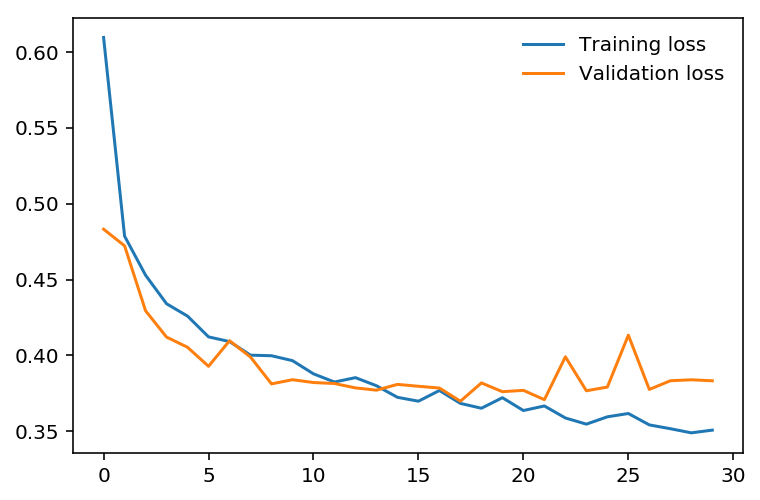

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

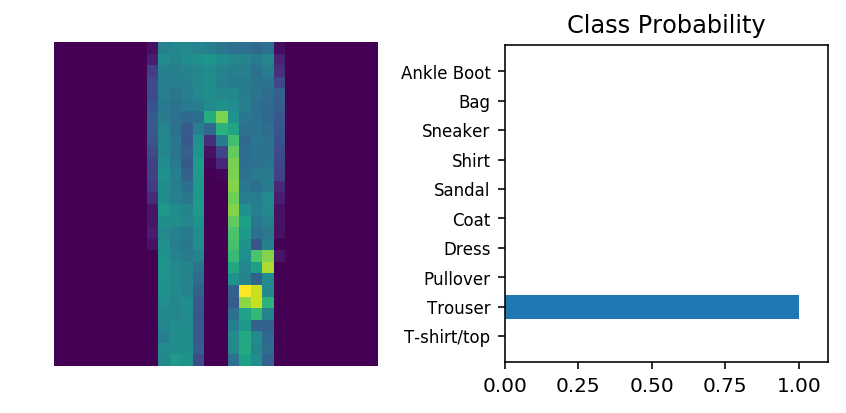

In [12]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(-1,784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')